# Heartbeat of the New York City Subway

## Data source
**MTA.info** (Turnstile data)  http://web.mta.info/developers/turnstile.html  
**Underweather**  
**Twitter**  
**Yelp** ...

## Motivation
1. The data is open, free and comprehensive.
2. "Stand on the shoulders of Giants".
2. "Smarter cities" (Turning Big Data into Insight).

## 1. Pre-processing
<a id='section1a'></a>
### a. Data scraping
For data scraping, I implemented the function to automatically search and download the turnstile data from website for our interested time interval,  
e.g. ['150401','150409'].

In [ ]:
import pandas as pd
import xlrd
import urllib2
import re
from datetime import datetime, timedelta

In [ ]:
# Find the correct URL that contains the turnstile information of the given date
def FindURL(date):
    '''
    date: a list of one or two dates as strings, in the format of "%y%m%d"
    This function finds the right URL to pull data from. It expects a list input with length of 1 or 2. 
    For inputs of one-element list, the function will output the corresponding URL in a list;
    for inputs of two-elements list, the function will output URLs that cover the whole time range between the two dates.
    '''
    response = urllib2.urlopen('http://web.mta.info/developers/turnstile.html')
    html  = response.read()
    
    # Get all available data URLs
    availableData = re.findall(r'data\/nyct\/turnstile\/turnstile_[0-9]{6}\.txt', str(html))
    availableDataURL = ['http://web.mta.info/developers/' + x for x in availableData]
    
    # If only reading one day data
    if len(date)==1:
        date = datetime.strptime(date[0], '%y%m%d')
        week = []
        for i in range(7):
            temp_date = date + timedelta(days=i+1)
            week.append(temp_date.strftime('%y%m%d'))
        
        # Try all possible combination and match it against available URLs
        for eachDay in week:
            found = re.findall('http:\/\/web\.mta\.info\/developers\/data\/nyct\/turnstile\/turnstile_'+eachDay+'\.txt', 
                               str(availableDataURL))
            if found:
                break               
        return found
    
    # If reading data for a time period
    elif len(date)==2:
        date = [datetime.strptime(item, '%y%m%d') for item in date]
        beginDate = min(date)
        endDate = max(date) + timedelta(days=6)
        iterDate = beginDate + timedelta(days=1)
        urlList = []
        while iterDate <= (endDate + timedelta(days=1)):
            tempDate = iterDate.strftime('%y%m%d')
            found = re.findall('http:\/\/web\.mta\.info\/developers\/data\/nyct\/turnstile\/turnstile_'+ tempDate +'\.txt', 
                               str(availableDataURL))
            urlList += found
            iterDate += timedelta(days=1)
        return urlList
    
    # Raise error if input is not in the right format
    else:
        raise ValueError("Input must be a list of length one or two!")

In [ ]:
# Retrieve the information from the given URL, and store it as DataFrame
def ReadSingleData(url):
    '''
    url: A string of URL
    This function returns the corresponding data of that url.
    '''
    # Get the target date
    date = re.findall('[0-9]{6}', url)[0]
    if url:
        # Data before 2014-10-11 has different structures than data afterwards
        if datetime.strptime(date, '%y%m%d') < datetime.strptime('141011', '%y%m%d'):
            column_string='C/A,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,DESC2,ENTRIES2,EXITS2,'+ \
            'DATE3,TIME3,DESC3,ENTRIES3,EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4,DATE5,TIME5,DESC5,ENTRIES5,EXITS5,'+ \
            'DATE6,TIME6,DESC6,ENTRIES6,EXITS6,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8'
            column_names=column_string.split(',')
            
            # Some NULL characters are messing the pd.read_csv function
            data=pd.read_csv(url, names=column_names, sep='\x00?,', engine='python')
            
            globalColumn1 = ['C/A', 'UNIT', 'SCP']
            globalColumn2 = ['DATE','TIME','DESC','ENTRIES','EXITS']
            
            for i in range(8):       
                colNeeded=globalColumn1 + [ x + str(i+1) for x in globalColumn2 ]
                if i==0:
                    sub_outputDF = pd.DataFrame(data[colNeeded])
                    sub_outputDF.columns=globalColumn1+globalColumn2
                else:
                    tempDF = pd.DataFrame(data[colNeeded])
                    tempDF.columns=globalColumn1+globalColumn2
                    sub_outputDF = pd.concat([sub_outputDF, tempDF], ignore_index=True)
            
            # Create TIME column for easier time subsetting
            sub_outputDF['TIME'] = sub_outputDF['DATE'] + ' ' + sub_outputDF['TIME']
            sub_outputDF['TIME'] = pd.to_datetime(sub_outputDF['TIME'], format='%m-%d-%y %H:%M:%S')
            sub_outputDF = sub_outputDF.drop('DATE', 1)
            sub_outputDF.dropna(axis=0, how='all', subset=['ENTRIES','EXITS'], inplace=True)
            
            # Merge with master file of stations
            stationMap = pd.read_excel('http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls')
            stationMap.columns = ['UNIT', 'C/A', 'STATION', 'LINENAME', 'DIVISION']
            outputDF = pd.merge(left=sub_outputDF, right=stationMap, how='left', on=['UNIT', 'C/A'], sort=False)
            orderedColumns = ['DIVISION', 'STATION', 'C/A', 'UNIT', 'SCP', 'LINENAME', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
            outputDF = outputDF[orderedColumns]

        else:
            header = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
            outputDF=pd.read_csv(url, names=header, skiprows=1)
            
            outputDF['TIME'] = outputDF['DATE'] + ' ' + outputDF['TIME']
            outputDF['TIME'] = pd.to_datetime(outputDF['TIME'], format='%m/%d/%Y %H:%M:%S')
            outputDF = outputDF.drop('DATE', 1)
            outputDF.dropna(axis=0, how='any', inplace=True)
            orderedColumns = ['DIVISION', 'STATION', 'C/A', 'UNIT', 'SCP', 'LINENAME', 'TIME', 'DESC', 'ENTRIES', 'EXITS']
            outputDF = outputDF[orderedColumns]
    else:
        outputDF=[]
    
    return outputDF

In [ ]:
def ReadData(date):
    '''
    date: a list of one or two dates as strings, in the format of "%y%m%d"
    This function returns the corresponding data of inputs. It expects a list input with length of 1 or 2. 
    For inputs of one-element list, the function will output data of that single day;
    for inputs of two-elements list, the function will output data of the time periods between the two days.
    '''
    if len(date) < 3:
        urlList = FindURL(date)
        data = pd.DataFrame()
        for url in urlList:
            temp = ReadSingleData(url)
            data = data.append(temp)
    else:
        raise ValueError("Input must be a list of length one or two!")
    
    date = [datetime.strptime(item, '%y%m%d') for item in date]
    beginDate = min(date)
    endDate = max(date) + timedelta(days=1)
    
    # Subset to desired time range
    output = data[(data['TIME'] >= beginDate) & (data['TIME'] <= endDate)]
    output.reset_index(drop=True, inplace=True)
    
    # Sort data frame for future calculation of interval entry
    output.sort_values(['DIVISION', 'STATION', 'C/A', 'UNIT', 'SCP', 'TIME'], inplace=True)
    output.reset_index(drop=True, inplace=True)
    
    return output

<a id='section1b'></a>
### b. Data cleaning 
 * Calculate the entry/exit number of passengers between time intervals
 * Remove all the negative entry/exit numbers
 * Remove the unrealistic extreme large values using 99% quantile

In [ ]:
def DataClean(data):
    # Make sure data is sorted accordingly
    data.sort_values(['DIVISION','STATION', 'C/A', 'UNIT', 'SCP', 'TIME'], inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    # Calculate interval entries and exits
    intervalEntry = data.groupby(['C/A', 'UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x-x.shift()).fillna(0)
    intervalExit = data.groupby(['C/A', 'UNIT', 'SCP'])['EXITS'].transform(lambda x: x-x.shift()).fillna(0)
    
    # Get rid of negative values
    intervalEntry[intervalEntry<0] = 0
    intervalExit[intervalExit<0] = 0
    
    # Capping interval entries and exits using 99% quantile
    capEntry = intervalEntry.quantile(0.99)
    capExit = intervalExit.quantile(0.99)
    intervalEntry[intervalEntry>capEntry] = 0
    intervalExit[intervalExit>capExit] = 0

    # Add columns to data
    data['intvlEntry'] = pd.Series(intervalEntry, index = data.index)
    data['intvlExit'] = pd.Series(intervalExit, index = data.index)
    
    # Drop the previous "Entry" and "Exit" columns
    data.drop(['ENTRIES','EXITS'],axis = 1,inplace= True)
    
    return data

**Live Code Session 1 -- Data scraping and cleaning**  
  * **FindURL(dates)**: Find the correct url for the dates in interest
  * **ReadSingleData(url)**: Read the information from given url, and store it in DataFrame  
  * **ReadData(dates)**: FindURL + ReadSingleData (applied for multiple urls)
  * **DataClean(data)**: Pre-process and clean the dataframe

In [1]:
dates = ['150701','150730']
sub_data = ReadData(dates)
sub_data = DataClean(sub_data)

# fname_csv = 'NYCT' + '_'.join(dates) + '.csv'
# sub_data.to_csv(fname_csv)

NameError: name 'ReadData' is not defined

In [ ]:
sub_data.head()

## 2. Exploratory analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
def Parse_Time(data):
    
    data['TIME'] = pd.to_datetime(data['TIME'],format='%Y/%m/%d %H:%M:%S')
    data['Month'] = pd.Series([x.date().month for x in data['TIME']])
    data['Day'] = pd.Series([x.date().day for x in data['TIME']])
    data['Hour'] = pd.Series([x.time().hour for x in data['TIME']])
    data['Weekday'] = pd.Series([x.date().weekday() for x in data['TIME']])
    
    Weekday_dict = { 0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thur', 4: 'Fri', 5:'Sat', 6:'Sun'}
    Month_dict = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9:'Sep', 10:'Oct', 11:'Nov',12: 'Dec'}
    data['Weekday'] = data['Weekday'].map(Weekday_dict)
    data['Month'] = data['Month'].map(Month_dict)    
    
    return data

In [ ]:
#sub_data = pd.read_csv(fname_csv)
#sub_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
sub_data = Parse_Time(sub_data)

### a. Temporal pattern

<a id='Q1'></a>
### Q1: How are numbers of entries/exits changing daily for a subway station?

In [ ]:
def Visualize_Station_hist(sub_data, station_name, time_period):
    
    temp = sub_data[sub_data.STATION == station_name]
    station_data = temp[(temp.TIME > time_period[0])&(temp.TIME < time_period[1])]
    station_data.sort_values(['TIME'], inplace = True)
    
    station_entry_exit_hist = station_data.groupby('TIME')['intvlEntry','intvlExit'].sum()
    station_entry_exit_hist.plot(figsize = (12,6),linestyle='--',marker='o')
    plt.ylim([0,2*station_entry_exit_hist.max().max()])
    
    return station_entry_exit_hist

**Live code session:**

C:\Users\Satellite\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


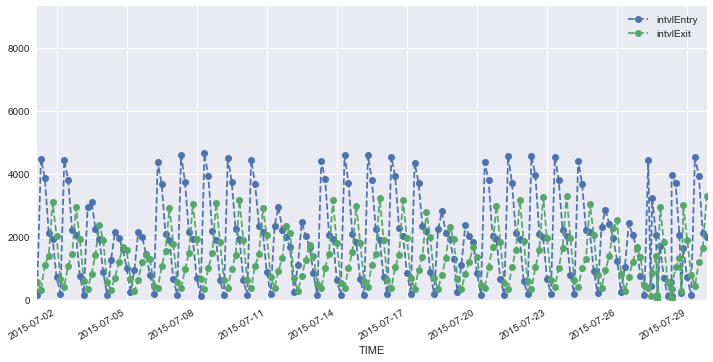

In [33]:
## Candidate stations: '14 ST-UNION SQ', '104 ST', '111 ST', '121 ST' ...

station_entry_exit_hist = Visualize_Station_hist(sub_data,  '111 ST',[datetime(2015,7,1),datetime(2015,7,30)])

<a id='Q2'></a>
### Q2: What are the total number of entries & exits across the city everyday ?

In [ ]:
weekday_entry = sub_data.groupby(['Weekday','Day'])['intvlEntry'].sum()
weekday_entry_ave = weekday_entry.unstack().mean(axis = 1).reindex(['Mon','Tue','Wed','Thur','Fri', 'Sat','Sun'])
weekday_exit = sub_data.groupby(['Weekday','Day'])['intvlExit'].sum()
weekday_exit_ave = weekday_exit.unstack().mean(axis = 1).reindex(['Mon','Tue','Wed','Thur','Fri', 'Sat','Sun'])

entry_exit_ave = pd.concat([weekday_entry_ave, weekday_exit_ave],axis = 1)
entry_exit_ave = entry_exit_ave/1000
entry_exit_ave.columns = ['Entry', 'Exit']

In [ ]:
#weekday_entry

**Live code session:**

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

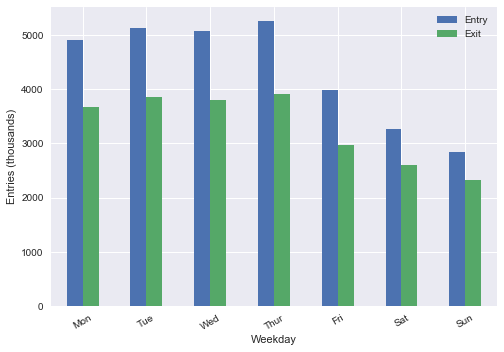

In [32]:
entry_exit_ave.plot(kind = 'bar')
plt.ylabel('Entries (thousands)')
plt.xticks(rotation=30)


### Q3: What is the busiest time of a week?

In [ ]:
# Create features "Busyness" and "Net_flow_in"
sub_data['Busyness'] = sub_data['intvlExit'] + sub_data['intvlEntry']
sub_data['Net_flow_in'] = sub_data['intvlEntry']-sub_data['intvlExit']

In [ ]:
# Further format the data into six time groups
def group_time(x):
    if x>=0 and x<4:
        return '0 - 4'
    elif x < 8:
        return '4 - 8'
    elif x < 12:
        return '8 - 12'
    elif x < 16:
        return '12 - 16'
    elif x < 20:
        return '16 - 20'
    elif x < 24:
        return '20 - 24'
    
sub_data['time_group'] = sub_data['Hour'].apply(group_time)

In [31]:
sub_weekly = sub_data.groupby(['time_group','Weekday'])['Busyness','Net_flow_in'].mean().reindex(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'],level = 1)
sub_weekly.reindex(['0 - 4', '4 - 8','8 - 12', '12 - 16','16 - 20', '20 - 24'],level = 0).unstack()
sub_weekly_busyness = sub_weekly['Busyness'].unstack().reindex(['0 - 4', '4 - 8','8 - 12', '12 - 16','16 - 20', '20 - 24'])
sub_weekly_busyness = sub_weekly_busyness.astype(int)

sub_weekly_netflow = sub_weekly['Net_flow_in'].unstack().reindex(['0 - 4', '4 - 8','8 - 12', '12 - 16','16 - 20', '20 - 24'])
sub_weekly_netflow = sub_weekly_netflow.astype(int)

<a id='Q3'></a>
**Live code session:**

In [ ]:
def prepare_plot_data(day, time_group):
    
    if (day in ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']):
        sub_day_data = sub_data[sub_data['Weekday']== day]
    else:
        sub_day_data = sub_data[sub_data['Day']== int(day)]
        
    station_netflow = sub_day_data.groupby(['STATION', 'time_group'])['Net_flow_in'].mean()
    station_netflow.reindex(['0 - 4', '4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24'], level=1)
    
    station_busyness = sub_day_data.groupby(['STATION', 'time_group'])['Busyness'].mean()
    station_busyness.reindex(['0 - 4', '4 - 8', '8 - 12', '12 - 16', '16 - 20', '20 - 24'], level=1)
    
    station_netflow = station_netflow.unstack()
    station_busyness = station_busyness.unstack()
    
    station_netflow = station_netflow.merge(nyc_station_longlat,left_index = True, right_index = True)
    station_busyness = station_busyness.merge(nyc_station_longlat,left_index = True, right_index = True)
    
    busyness_data = station_busyness[['latitude', 'longitude', time_group]]
    netflow_data = station_netflow[[time_group]]
    plot_data = busyness_data.merge(netflow_data, left_index=True, right_index=True)
    x_column_name = time_group+'_x'
    y_column_name = time_group+'_y'
    plot_data = plot_data.rename(columns = {x_column_name: 'busyness', y_column_name: 'netflow'})
    return plot_data

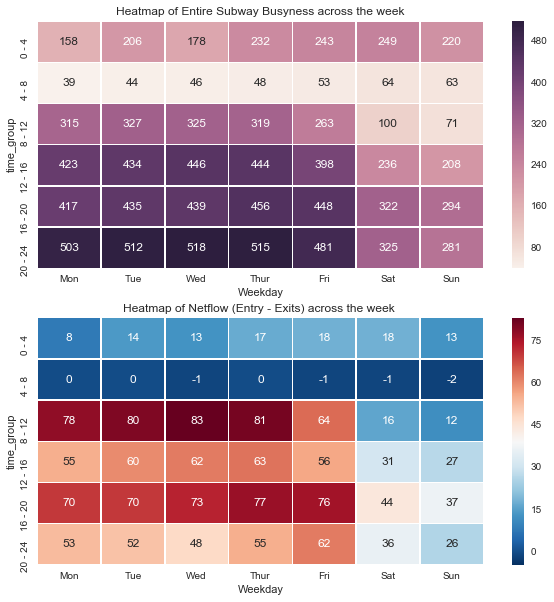

In [29]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
sns.heatmap(sub_weekly_busyness,annot = True, fmt="d", linewidths=.5, cbar = True, ax=ax1)
ax1.set_title('Heatmap of Entire Subway Busyness across the week')

sns.heatmap(sub_weekly_netflow,annot = True, fmt="d", linewidths=.5, cbar = True, center =sub_weekly_netflow.mean().mean(),ax=ax2)
ax2.set_title('Heatmap of Netflow (Entry - Exits) across the week ')
plt.show()


### Q4: How are passengers moving across the city?

In [ ]:
nyc_station_location = pd.read_csv('turnstile_weather_v2.csv')
nyc_station_longlat = nyc_station_location [['station', 'latitude','longitude']].groupby(['station'])['latitude','longitude'].mean()

In [ ]:
def transform_coordinates(series, old_origin, old_width, new_origin, new_width):
    old_origin = float(old_origin)
    old_width = float(old_width)
    new_origin = float(new_origin)
    new_width = float(new_width)
    return new_origin + (series - old_origin) / old_width * new_width

In [ ]:
import matplotlib.lines as lines
day_dict={'Mon': "Monday", 'Tue': 'Tuesday', 'Wed': "Wednesday", 'Thu': 'Thursday', 
          'Fri':'Friday', 'Sat':'Saturday','Sun':'Sunday'}
# time_group_dict = {'0 - 4':'0:00-4:00','4 - 8':'4:00-8:00','8 - 12':'8:00 - 12:00',
#                    '12 - 16':'12:00-16:00','16 - 20':'16:00-20:00','20 - 24':'20:00-24:00'}
def spatial_plot(day, time_group): 
    img = plt.imread('new-york.png')
    strlist = time_group.split(' ')
    if (day in ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']):
        title = "NYC Subway Passenger Flow on " + day_dict[day] + ' during ' + strlist[0] +':00' + '-' + strlist[2] +':00'
    else:
        title = "NYC Subway Passenger Flow on  Day " + day + ' during ' + strlist[0] +':00' + '-' + strlist[2] +':00'
    ypixels, xpixels, bands = img.shape
    dpi = 72.
    xinch = xpixels / dpi
    yinch = ypixels / dpi
    fig = plt.figure(figsize=(xinch/2.0, yinch * 0.5/ .85))
    plot_data = prepare_plot_data(day, time_group)
    xpos = transform_coordinates(plot_data['longitude'], -74.1, .35, 0, xpixels)
    ypos = transform_coordinates(plot_data['latitude'], 40.55, .35, ypixels, -ypixels)

    plt.axes([0., 0., 1., .9], frameon=False, xticks=[], yticks=[])
    # plot background image with map
    plt.imshow(img, interpolation='none')
    plt.scatter(x = xpos, y = ypos, c=plot_data['netflow'], s=plot_data['busyness']/8,
                cmap = 'seismic', linewidths= 0, alpha=0.7)
    plt.xlim(0, xpixels)
    plt.ylim(ypixels, 0)
    fig.suptitle(title, fontsize=16)
    dot1 = lines.Line2D([0], [0], c='white', marker='o', mfc='yellow', ms=4, mew=0)
    dot2 = lines.Line2D([0], [0], c='white', marker='o', mfc='yellow', ms=8, mew=0)
    dot3 = lines.Line2D([0], [0], c='white', marker='o', mfc='red', ms=6, mew=0)
    dot4 = lines.Line2D([0], [0], c='white', marker='o', mfc='blue', ms=6, mew=0)
    legend = plt.legend([dot1, dot2, dot3, dot4],
            ['Stations with less passengers',
             'Stations with more passengers',
             'Stations with more people entering',
             'Stations with more people exiting'],  bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0., fontsize=9)

    return plt

<a id='Q4'></a>
**Live code session:**

In [28]:
## run Parse_time
spatial_plot('Tue','8 - 12')


IOError: [Errno 2] No such file or directory: 'new-york.png'